In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 3.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=dbfaea6854026feb2ee0cf7c47e2dac7a57fe75f3f71942f32ae09bbb40553e3
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [ ]:
#!pip install databento

In [5]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import datetime
from datetime import datetime as dt
import gc

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv2D, LeakyReLU, BatchNormalization, Dropout, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

print("TensorFlow version: {}".format(tf.__version__))

import warnings
warnings.filterwarnings("ignore")

TensorFlow version: 2.16.1


In [6]:
import yfinance as yf
#import databento as db

In [7]:
print("GPU Available: ", tf.test.is_gpu_available())
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", tf.config.list_physical_devices('GPU'))

if tf.test.is_gpu_available():
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = None
print("Execution Strategy: ", strategy)

GPU Available:  False
Number of GPUs Available:  0
GPUs:  []
Execution Strategy:  None


In [8]:
def simulate_gbm(n, N=252):
    # Parameters for the simulation
    S0 = 100  # Initial stock price
    mu = 0.05  # Expected return (drift)
    sigma = 0.2  # Volatility (standard deviation)
    T = 1  # Time period (e.g., 1 year)
    #N = 252  # Number of time steps (e.g., 252 trading days in a year)
    dt = T / N  # Time step size
    all_paths = np.zeros((n, N))
    for i in range(n):
        # Simulate stock prices
        S = np.zeros(N)
        S[0] = S0
        for t in range(1, N):
            Z_t = np.random.normal(0, 1)  # Generate a random standard normal variable
            S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_t)
        all_paths[i] = S

    return all_paths

(100, 252)


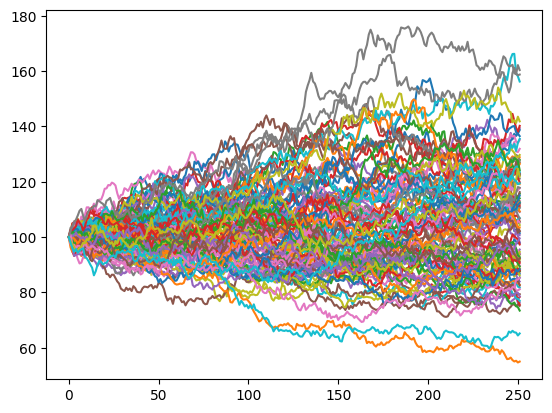

In [9]:
paths = simulate_gbm(100)
print(paths.shape)
for i in paths:
    plt.plot(i)

In [10]:
d = yf.download("NVDA", start="1962-07-01", end=dt.today())
print(d.shape)
print(d.columns)
d.head()

[*********************100%***********************]  1 of 1 completed

(6468, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037618,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041559,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038334,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038215,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038095,227520000


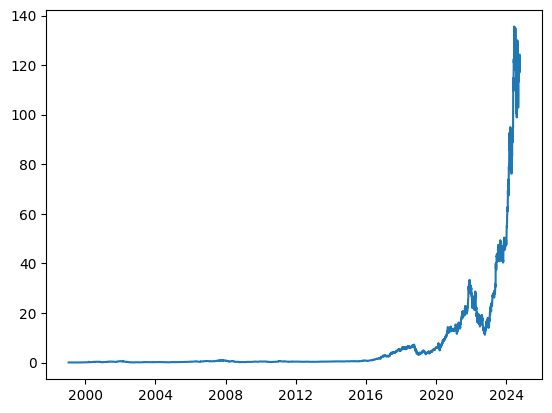

In [11]:
plt.plot(d["Close"])

In [12]:
class DataLoader:
    def __init__(self, data=None, data_shape=0, returns=False, scaling_method="standardize"):
        self.data_shape = data_shape
        self.returns = returns
        self.data = None
        self.raw_data = None
        self.scaler = None
        if scaling_method == "standardize":
            self.scaler = StandardScaler()
        elif scaling_method == "minmax":
            self.scaler = MinMaxScaler()
        self._query_market_data(data)
    
    def _query_market_data(self, data):
        self.data = yf.download("NVDA", start="1962-07-01", end=dt.today())["Close"].to_numpy()
        self.raw_data = self.data
        # preprocessing
        if self.returns:
            self.data = np.log(self.data[1:]/self.data[:-1])  # log returns
        if self.scaler is not None:
            self.data = self.scaler.fit_transform(self.data.reshape(-1, 1))
        rolling_sequences = []
        for i in range(len(self.data)-self.data_shape):
            rolling_sequences.append(self.data[i:i+self.data_shape])
        self.data = np.array(rolling_sequences)
        
    def _preprocess(self, data):
        if self.returns:
            data = np.log(data[1:]/data[:-1])  # log returns
        if self.scaler is not None:
            data = self.scaler.fit_transform(data.reshape(-1, 1))
        rolling_sequences = []
        for i in range(len(data)-self.data_shape):
            rolling_sequences.append(data[i:i+self.data_shape])
        return np.array(rolling_sequences)
        
    def generate_data_gbm(self, n=100):
        prices = simulate_gbm(n, N=self.data_shape+1 if self.returns else self.data_shape)
        self.raw_data = prices
        self.data = prices
        # preprocessing
        if self.returns:
            returns = self.data[:, 1:] / self.data[:, :-1]
            #returns = np.hstack([np.ones((self.data.shape[0], 1)), returns])  # keep returns length same as original price path
            self.data = np.log(returns)  # log returns
        if self.scaler is not None:
            self.data = self.scaler.fit_transform(self.data)
        return self.data
    
    def generate_data(self, n=100):
        idx = np.random.choice(self.data.shape[0], n, replace=False)
        return self.data[idx]
    
    def generate_real_samples(self, n, lstm=False):
        #X = self.generate_data_gbm(n)
        X = self.generate_data(n)
        if lstm:
            X = X.reshape((n, self.data_shape, 1))
        else:
            X = X.reshape((n, self.data_shape))
        y = np.ones((n, 1))
        return X, y
    
    def reverse_preprocessing(self, data, initial_price=100):
        """
        Undo scaling and log returns to get raw prices.
        """
        data = data.reshape((data.shape[0], self.data_shape))
        # Reverse scaling
        log_returns = self.scaler.inverse_transform(data)
        returns = np.exp(log_returns)
        # Reverse log returns, recover the original price series
        initial_prices = initial_price*np.ones((data.shape[0], 1))
        original_prices = initial_prices * np.cumprod(returns, axis=1)
        return original_prices
        
    def get_raw_data(self):
        return self.raw_data
    
    def get_raw_data_sample(self):
        idx = np.random.randint(self.raw_data.shape[0]-self.data_shape)
        return self.raw_data[idx:idx+self.data_shape]


dataloader = DataLoader(data_shape=252, returns=True, scaling_method="standardize")
data, _ = dataloader.generate_real_samples(1000)

[*********************100%***********************]  1 of 1 completed


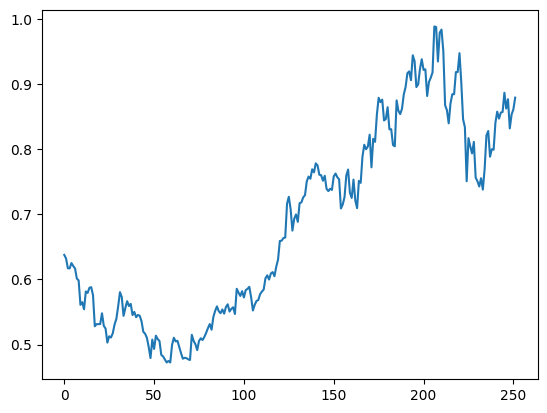

In [13]:
plt.plot(dataloader.get_raw_data_sample())

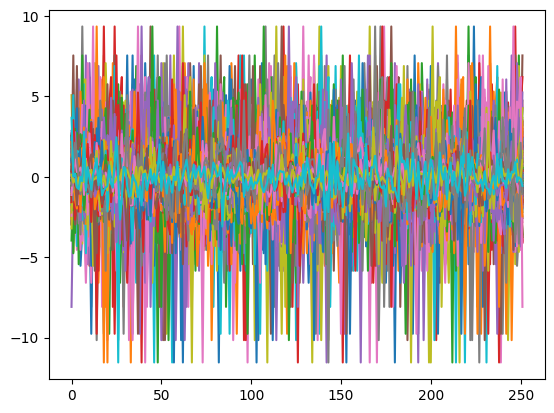

In [14]:
for i in range(len(data)):
    plt.plot(data[i])

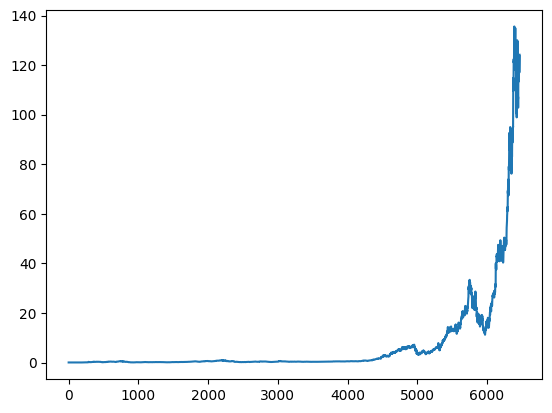

In [15]:
raw = dataloader.get_raw_data()
#for i in range(len(raw)):
#    plt.plot(raw[i])
plt.plot(raw)

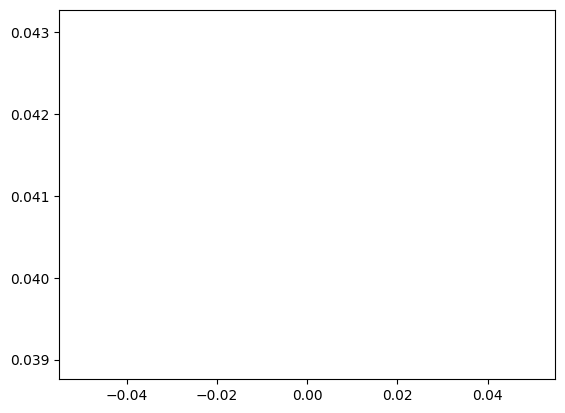

In [16]:
plt.plot(raw[0])

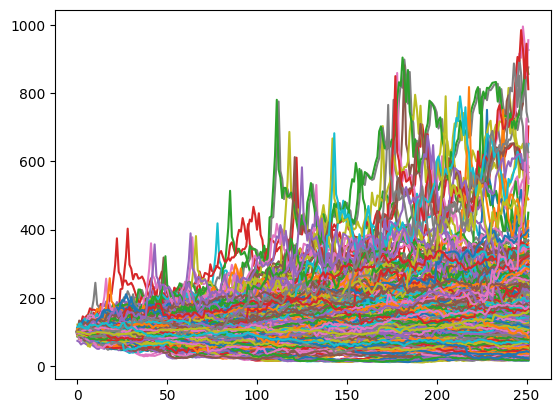

In [17]:
reverse = dataloader.reverse_preprocessing(data)
for i in range(len(reverse)):
    plt.plot(reverse[i])

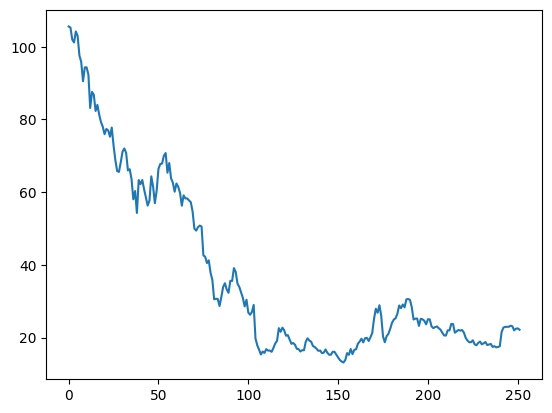

In [18]:
plt.plot(reverse[0])

In [19]:
def build_discriminator(data_shape):
    discriminator = Sequential()
    discriminator.add(Dense(64, activation="relu", input_dim=data_shape))
    discriminator.add(Dense(128, activation="relu"))
    #discriminator.add(LSTM(128, return_sequences=True, input_shape=(data_shape, 1)))
    #discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    #discriminator.add(LSTM(256))
    #discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return discriminator

In [20]:
def build_critic(data_shape):
    critic = Sequential()
    #critic.add(LSTM(128, return_sequences=True, input_shape=(data_shape, 1)))
    critic.add(Dense(64, input_dim=data_shape))
    critic.add(LeakyReLU(alpha=0.2))
    #critic.add(LSTM(256))
    critic.add(Dense(128))
    critic.add(LeakyReLU(alpha=0.2))
    critic.add(Dense(256))
    critic.add(LeakyReLU(alpha=0.2))
    critic.add(Dense(1, activation="linear"))
    return critic

In [21]:
def build_generator(latent_dim, data_shape, features=1):
    generator = Sequential()
    generator.add(Dense(64, input_dim=latent_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(128))
    #generator.add(LSTM(128, return_sequences=True, input_shape=(latent_dim, 1)))
    generator.add(LeakyReLU(alpha=0.2))
    #generator.add(LSTM(256))
    #generator.add(LeakyReLU(alpha=0.2))
    #generator.add(BatchNormalization())
    generator.add(Dense(256))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(data_shape, activation="linear"))
    #generator.add(Reshape((data_shape, features)))  # for LSTM Discriminator input
    return generator

In [22]:
def generate_noise(latent_dim, n):
    noise = np.random.randn(latent_dim*n)
    return noise.reshape(n, latent_dim)

In [23]:
class BaseGAN:
    def __init__(self, latent_dim, data_shape):
        self.latent_dim = latent_dim
        self.data_shape = data_shape

## Vanilla GAN

In [ ]:
class GAN:
    def __init__(self, latent_dim, data_shape, name="default"):
        self.name = name
        self.latent_dim = latent_dim
        self.data_shape = data_shape
        self.generator = build_generator(latent_dim, data_shape)
        self.discriminator = build_discriminator(data_shape)
        self._build_gan()
        self.get_gan_summary()
        self._checkpoints()
        
    def _build_gan(self):
        self.discriminator.trainable = False
        self.gan = Sequential()
        self.gan.add(self.generator)
        self.gan.add(self.discriminator)
        self.gan.compile(loss='binary_crossentropy', optimizer='adam')
        
    def _checkpoints(self):
        # Model checkpoints
        self.generator_checkpoint = ModelCheckpoint('./sinxplusx_generator_checkpoint.weights.h5', 
                                       save_weights_only=True, 
                                       save_best_only=False, 
                                       verbose=1)
        #self.generator_checkpoint.model = self.generator

        self.discriminator_checkpoint = ModelCheckpoint('./sinxplusx_discriminator_checkpoint.weights.h5', 
                                           save_weights_only=True, 
                                           save_best_only=False, 
                                           verbose=1)
        #self.discriminator_checkpoint.model = self.discriminator

        self.gan_checkpoint = ModelCheckpoint('./sinxplusx_gan_checkpoint.weights.h5', 
                                 save_weights_only=True, 
                                 save_best_only=False, 
                                 verbose=1)
        #self.gan_checkpoint.model = self.gan
        
    def _save_checkpoints(self, epoch, remove_old=False):
        self.generator.save_weights('./{}_generator_epoch_{}.weights.h5'.format(self.name, epoch))
        if remove_old and os.path.exists('./{}_generator_epoch_{}.weights.h5'.format(self.name, epoch-1)):
            os.remove('./{}_generator_epoch_{}.weights.h5'.format(self.name, epoch-1))
        self.discriminator.save_weights('./{}_discriminator_epoch_{}.weights.h5'.format(self.name, epoch))
        if remove_old and os.path.exists('./{}_discriminator_epoch_{}.weights.h5'.format(self.name, epoch-1)):
            os.remove('./{}_discriminator_epoch_{}.weights.h5'.format(self.name, epoch-1))
        self.gan.save_weights('./{}_gan_epoch_{}.weights.h5'.format(self.name, epoch))
        if remove_old and os.path.exists('./{}_gan_epoch_{}.weights.h5'.format(self.name, epoch-1)):
            os.remove('./{}_gan_epoch_{}.weights.h5'.format(self.name, epoch-1))
        
    def generate_noise(self, n, lstm=True):
        noise = np.random.randn(self.latent_dim*n)
        if lstm:
            return noise.reshape(n, self.latent_dim, 1)
        return noise.reshape(n, self.latent_dim)
        
    def generate_data(self, n):
        noise = self.generate_noise(n)
        # generator predict
        synthetic_data = self.generator.predict(noise)
        return synthetic_data
    
    def generate_fake_samples(self, n):
        return self.generate_data(n), np.zeros((n, 1))
    
    def fit(self, dataloader, epochs, batch_size, eval_period=100, save_checkpoints=True):
        half_batch = int(batch_size/2)
        self.d_losses = np.array([])
        self.g_losses = np.array([])
        for epoch in tqdm(range(epochs)):
            # generator fake data
            x_fake, y_fake = self.generate_fake_samples(n=half_batch)
            x_real, y_real = dataloader.generate_real_samples(n=half_batch)
            d_loss_real = self.discriminator.train_on_batch(x_real, y_real)
            d_loss_fake = self.discriminator.train_on_batch(x_fake, y_fake)
            d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])
            self.d_losses = np.append(self.d_losses, d_loss)
            
            x_gan, y_gan = self.generate_noise(batch_size), np.ones((batch_size, 1))
            g_loss = self.gan.train_on_batch(x_gan, y_gan)
            self.g_losses = np.append(self.g_losses, g_loss)
            
            if (epoch+1)%eval_period == 0:
                self._summarize_performance(epoch+1, dataloader)
                if save_checkpoints:
                    #self.generator_checkpoint.on_epoch_end(epoch, g_loss)
                    #self.discriminator_checkpoint.on_epoch_end(epoch, d_loss)
                    #self.gan_checkpoint.on_epoch_end(epoch)
                    self._save_checkpoints(epoch+1)
            #gc.collect()
    
    def _summarize_performance(self, epoch, dataloader, n=100):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 9))
        # losses
        print(f"{epoch} [D loss: {self.d_losses[-1]:.4f}] [G loss: {self.g_losses[-1]:.4f}]")
        ax1.plot(self.g_losses, color="red")
        ax1.plot(self.d_losses, color="blue")
        ax1.legend(["Generator Loss", "Discriminator Loss"])
        # generator performance
        x_real, y_real = dataloader.generate_real_samples(n)
        _, real_acc = self.discriminator.evaluate(x_real, y_real, verbose=0)
        x_fake, y_fake = self.generate_fake_samples(n)
        _, fake_acc = self.discriminator.evaluate(x_fake, y_fake, verbose=0)
        print("Epoch: {}".format(epoch))
        print("Real Accuracy: {}; Fake Accuracy: {}".format(real_acc, fake_acc))
        #ax2.plot(x_real[0], color="red")
        #ax2.plot(x_fake[0], color="blue")
        #ax2.legend(["Real Data", "Fake Data"])
        original_prices = dataloader.reverse_preprocessing(x_real)
        for i in range(len(original_prices)):
            ax2.plot(original_prices[i])
        fake_prices = dataloader.reverse_preprocessing(x_fake)
        for i in range(len(fake_prices)):
            ax3.plot(fake_prices[i])
        plt.show()
        
    def load_generator(self, weights_path):
        self.generator.load_weights(weights_path)
        
    def load_discriminator(self, weights_path):
        self.disciminator.load_weights(weights_path)
        
    def load_gan(self, weights_path):
        self.gan.load_weights(weights_path)
        
    def load_weights(self, generator_weights, discriminator_weights, gan_weights):
        self.load_generator(generator_weights)
        self.load_discriminator(discriminator_weights)
        self.load_gan(gan_weights)
        
    def get_generator(self):
        return self.generator
        
    def get_generator_summary(self):
        print("Generator Summary:")
        print(self.generator.summary())
        
    def get_discriminator(self):
        return self.discriminator
        
    def get_discriminator_summary(self):
        print("Discriminator Summary:")
        print(self.discriminator.summary())
        
    def get_gan(self):
        return self.gan
        
    def get_gan_summary(self):
        print("GAN Summary:")
        print(self.gan.summary())

In [ ]:
#DATA_SHAPE = 252
#dataloader = DataLoader(data_shape=DATA_SHAPE, returns=True, scaling_method="standardize")

In [ ]:
#NAME = "gbm"
#LATENT_DIM = 100

#gan_model = GAN(name=NAME, 
#                latent_dim=LATENT_DIM, 
#                data_shape=DATA_SHAPE)

In [ ]:
#EPOCHS = 5000
#BATCH_SIZE = 128
#EVAL_PERIOD = 100

#gan_model.fit(dataloader,
#              epochs=EPOCHS,
#              eval_period=EVAL_PERIOD,
#              batch_size=BATCH_SIZE,
#              save_checkpoints=True)

## Wasserstein GAN with Gradient Penalty

In [69]:
class WGAN:
    def __init__(self, latent_dim, data_shape, learning_rate=0.00005, lstm=False, name="default"):
        self.name = name
        self.latent_dim = latent_dim
        self.data_shape = data_shape
        self.lstm = lstm
        self.learning_rate = learning_rate
        self.generator = build_generator(latent_dim, self.data_shape)
        self.critic = build_critic(self.data_shape)
        self._build_gan()
        
    def _build_gan(self):
        self.generator_optimizer = RMSprop(learning_rate=self.learning_rate)
        self.critic_optimizer = RMSprop(learning_rate=self.learning_rate)
        self.generator.compile(loss=self.wasserstein_loss, optimizer=self.generator_optimizer)
        self.critic.compile(loss=self.wasserstein_loss, optimizer=self.critic_optimizer)
        
    @staticmethod
    def wasserstein_loss(y_true, y_pred):
        return tf.reduce_mean(y_true*y_pred)
    
    def gradient_penalty(self, real_samples, fake_samples):
        #alpha = tf.random.uniform(shape=[real_samples.shape[0], 1], minval=0., maxval=1.)
        #interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        #with tf.GradientTape() as tape:
        #    tape.watch(interpolated)
        #    d_interpolated = self.critic(interpolated, training=True)
        #gradients = tape.gradient(d_interpolated, [interpolated])[0]
        #gradient_penalty = tf.reduce_mean(tf.square(tf.norm(gradients, axis=1) - 1))
        #return gradient_penalty
        # Create the interpolated image
        #if self.lstm:
        alpha = tf.random.uniform([real_samples.shape[0], 1], 0.0, 1.0)
        #else:
       #     alpha = tf.random.uniform([real_samples.shape[0], 1], 0.0, 1.0)
        interpolated = real_samples + alpha * (fake_samples - real_samples)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        #norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[0, 1]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def generate_noise(self, n):
        noise = np.random.randn(self.latent_dim*n)
        if self.lstm:
            return noise.reshape(n, self.latent_dim, 1)
        return noise.reshape(n, self.latent_dim)
    
    def generate_data(self, n):
        noise = self.generate_noise(n)
        synthetic_data = self.generator.predict(noise)
        return synthetic_data
    
    def generate_fake_samples(self, n):
        return self.generate_data(n), np.zeros((n, 1))
    
    def fit(self,
            dataloader, 
            epochs, 
            batch_size, 
            critic_iterations=5, 
            eval_period=100, 
            save_checkpoints=True, 
            checkpoints_path="/kaggle/working"):
        #real_labels = -np.ones((batch_size, 1))  # -1 for real samples in WGAN
        #fake_labels = np.ones((batch_size, 1))  # 1 for fake samples in WGAN
        half_batch = int(batch_size/2)
        self.c_losses = np.array([])
        self.g_losses = np.array([])
        for epoch in tqdm(range(epochs)):
            c_losses = np.array([])
            for _ in range(critic_iterations):
                x_fake, _ = self.generate_fake_samples(n=half_batch)
                x_real, _ = dataloader.generate_real_samples(n=half_batch)
                # Train the critic
                with tf.GradientTape() as disc_tape:
                    real_preds = self.critic(x_real, training=True)
                    fake_preds = self.critic(x_fake, training=True)
                    gp = self.gradient_penalty(x_real, x_fake)
                    c_loss = tf.reduce_mean(fake_preds) - tf.reduce_mean(real_preds) + 10 * gp
                    c_losses = np.append(c_losses, c_loss)
                gradients = disc_tape.gradient(c_loss, self.critic.trainable_variables)
                self.critic_optimizer.apply_gradients(zip(gradients, self.critic.trainable_variables))
            self.c_losses = np.append(self.c_losses, np.mean(c_losses))
            noise = self.generate_noise(batch_size)
            with tf.GradientTape() as gen_tape:
                fake_data = self.generator(noise, training=True)
                fake_preds = self.critic(fake_data, training=True)
                g_loss = -tf.reduce_mean(fake_preds)
                self.g_losses = np.append(self.g_losses, g_loss)

            gradients = gen_tape.gradient(g_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

            if (epoch+1)%eval_period==0:
                self._summarize_performance(epoch+1, dataloader)
                if save_checkpoints:
                    self.save_generator(os.path.join(checkpoints_path, "generator"), epoch+1)
                    self.save_critic(os.path.join(checkpoints_path, "critic"), epoch+1)
                
    def _summarize_performance(self, epoch, dataloader, n=100):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9))
        # losses
        print(f"{epoch} [C loss: {self.c_losses[-1]:.4f}] [G loss: {self.g_losses[-1]:.4f}]")
        ax1.plot(self.g_losses, color="red")
        ax1.plot(self.c_losses, color="blue")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend(["Generator Loss", "Critic Loss"])
        ax1.set_title("Generator vs. Critic Loss over Epochs")
        # generator performance
        #x_real, _ = dataloader.generate_real_samples(n)
        #x_fake, _ = self.generate_fake_samples(n)
        #original_prices = dataloader.reverse_preprocessing(x_real)
        #for i in range(len(original_prices)):
        #    ax2.plot(original_prices[i])
        #fake_prices = dataloader.reverse_preprocessing(x_fake)
        #for i in range(len(fake_prices)):
        #    ax3.plot(fake_prices[i])
        real = dataloader.get_raw_data_sample()
        fake, _ = self.generate_fake_samples(n)
        fake = dataloader.reverse_preprocessing(fake, initial_price=real[0])
        ax2.plot(real)
        for i in range(len(fake)):
            ax2.plot(fake[i], alpha=0.15)
        ax2.set_xlabel("Timestep")
        ax2.set_ylabel("Price")
        ax2.set_title("GAN Simulation of Market Returns")
        plt.show()
        
    def save_generator(self, path, epoch):
        if not os.path.exists(path):
            os.makedirs(path)
        self.generator.save_weights(os.path.join(path, "{}_generator_epoch_{}.weights.h5".format(self.name, epoch)))
        
    def save_critic(self, path, epoch):
        if not os.path.exists(path):
            os.makedirs(path)
        self.critic.save_weights(os.path.join(path, "{}_critic_epoch_{}.weights.h5".format(self.name, epoch)))

In [70]:
DATA_SHAPE = 252
dataloader = DataLoader(data_shape=DATA_SHAPE, returns=True, scaling_method="standardize")

[*********************100%***********************]  1 of 1 completed


In [71]:
name = "singlestock_NVDA"
LATENT_DIM = 100

wgan = WGAN(name=name,
            latent_dim=LATENT_DIM,
            data_shape=DATA_SHAPE,
            lstm=False)

  0%|          | 0/20 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 1/20 [00:01<00:34,  1.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 10%|█         | 2/20 [00:02<00:22,  1.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▌        | 3/20 [00:03<00:17,  1.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 4/20 [00:04<00:15,  1.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 25%|██▌       | 5/20 [00:05<00:13,  1.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 30%|███       | 6/20 [00:06<00:12,  1.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 7/20 [00:06<00:11,  1.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 8/20 [00:07<00:10,  1.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▌     | 9/20 [00:08<00:09,  1.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10 [C loss: 17.0351] [G loss: -0.0288]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


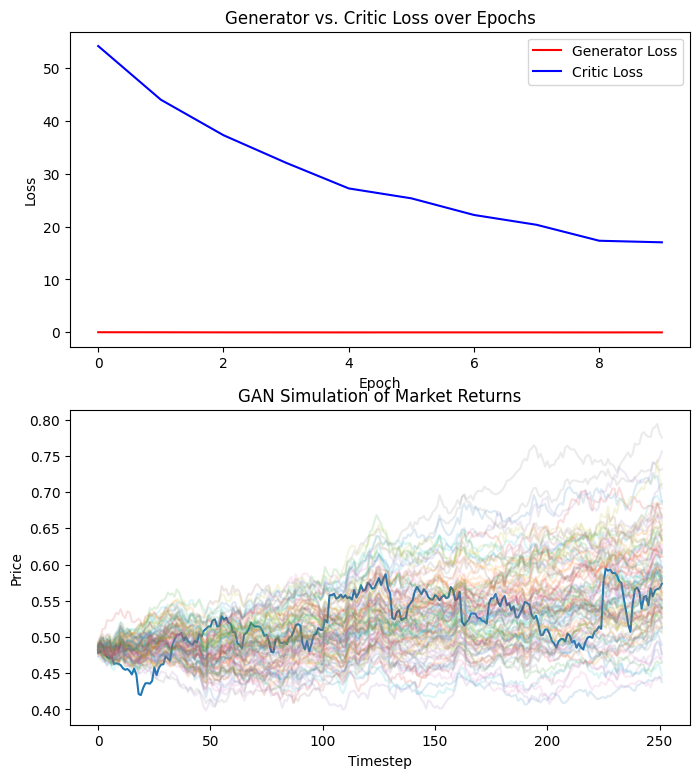

 50%|█████     | 10/20 [00:10<00:11,  1.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 11/20 [00:11<00:09,  1.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|██████    | 12/20 [00:11<00:07,  1.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▌   | 13/20 [00:12<00:06,  1.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 14/20 [00:13<00:05,  1.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 75%|███████▌  | 15/20 [00:14<00:04,  1.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|████████  | 16/20 [00:15<00:03,  1.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 17/20 [00:15<00:02,  1.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|█████████ | 18/20 [00:16<00:01,  1.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▌| 19/20 [00:17<00:00,  1.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
20 [C loss: 6.3257] [G loss: -0.0120]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


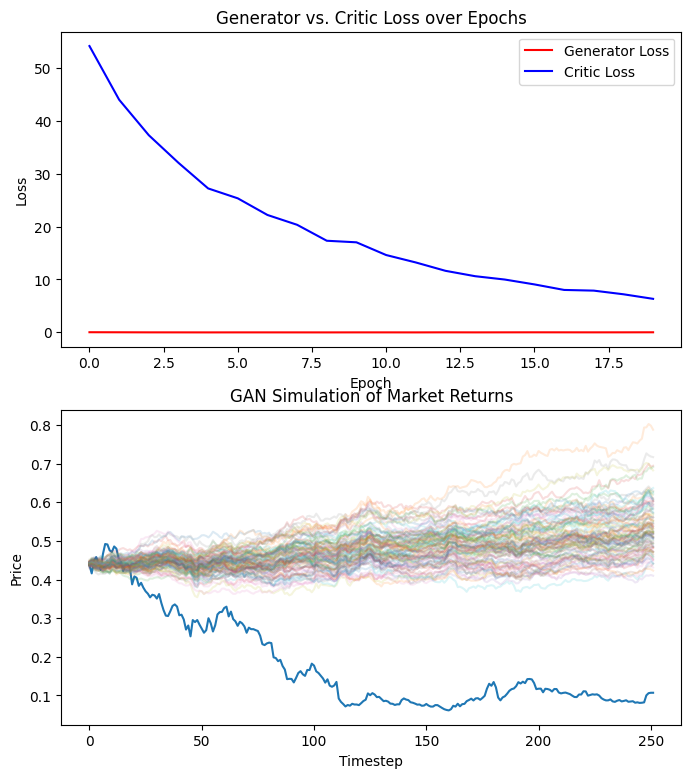

100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


In [72]:
EPOCHS = 5000
BATCH_SIZE = 128
EVAL_PERIOD = 10

wgan.fit(dataloader,
         epochs=EPOCHS,
         eval_period=EVAL_PERIOD,
         batch_size=BATCH_SIZE,
         save_checkpoints=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


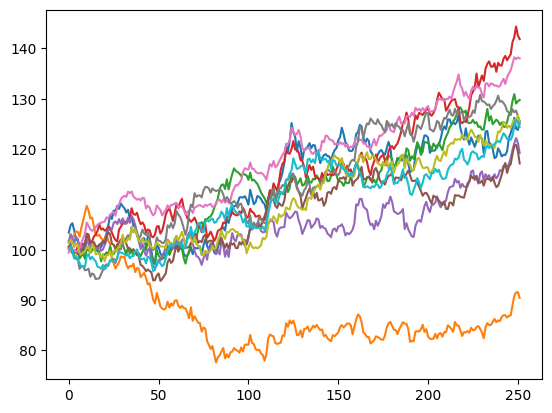

In [73]:
d, _ = wgan.generate_fake_samples(10)
dd = dataloader.reverse_preprocessing(d)
for i in range(len(dd)):
    plt.plot(dd[i])

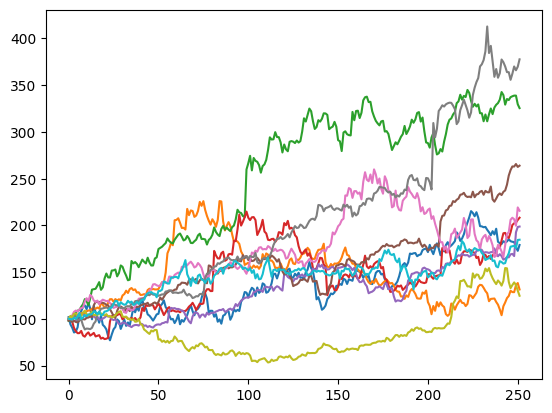

In [46]:
r, _ = dataloader.generate_real_samples(10)
rr = dataloader.reverse_preprocessing(r)
for i in range(len(rr)):
    plt.plot(rr[i])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Text(0, 0.5, 'Price')

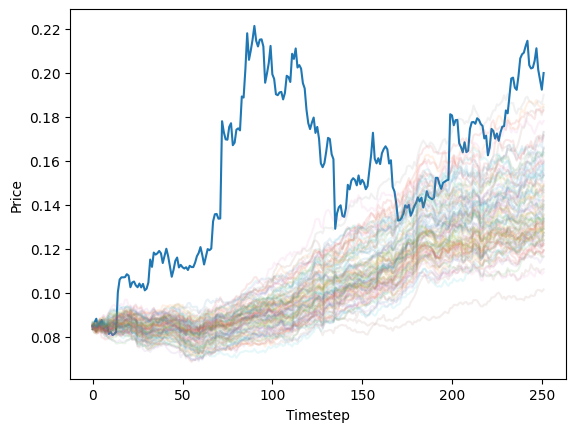

In [47]:
raw = dataloader.get_raw_data_sample()
f, _ = wgan.generate_fake_samples(100)
fake = dataloader.reverse_preprocessing(f, initial_price=raw[0])
plt.plot(raw)
for i in range(len(fake)):
    plt.plot(fake[i], alpha=0.1)
plt.xlabel("Timestep")
plt.ylabel("Price")